# Case study: re-analysis myeloid and erythroid differentiation of mouse (Mus musculus) single-cell data

This notebook will demonstrate scRNA-seq processing with `orthomap` using mouse scRNA data from [Paul et al., 2015](http://doi.org/10.1016/j.cell.2015.11.013).

scRNA data was obtained via Scanpy ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)).

see also:

- [https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html)
- [https://morris-lab.github.io/CellOracle.documentation/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.html](https://morris-lab.github.io/CellOracle.documentation/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.html)

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/paul15_example.ipynb](https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/paul15_example.ipynb)

## Steps

To process the scRNA data, we will do the following:

0. Run OrthoFinder to obtain orthogroups
1. Get query species taxonomic lineage information
2. Get query species orthomap
3. Map OrthoFinder gene names and scRNA gene/transcript names
4. Get TEI values and add them to scRNA dataset
5. Get partial TEI values to visualize gene age class contributions
6. Process scRNA data and visualize TEI

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [6, 4.5]
#plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import orthomap python package submodules

In [2]:
# import submodules
from orthomap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## Step 0 - run OrthoFinder to obtain orthogroups

`orthomap` can extract gene age classification from existing OrthoFinder results and link them with scRNA data.

A detailed how-to is available here:

https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html

However, any pre-calculated gene age classification can be imported as a table using the function `orthomap2tei.read_orthomap(orthomapfile=filename)`.

The pre-calculated gene age classification file should be <tab> delimited with two columns `GeneID<tab>Phylostratum`, like e.g.:
    
```
GeneID<tab>Phylostratum
WBGene00000001<tab>1
WBGene00000002<tab>1
WBGene00000003<tab>1
WBGene00000004<tab>1
WBGene00000005<tab>2
```

OrthoFinder ([Emms and Kelly, 2019](https://doi.org/10.1186/s13059-019-1832-y)) results (-S last) using translated, longest-isoform coding sequences (CDS) from [Ensembl release-110](https://ftp.ensembl.org/pub/release-110/), including species taxonomic IDs, are available here: 

https://doi.org/10.5281/zenodo.7242264

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.ensembl110_last(datapath='data')` (download folder set to `'data'`).

To be able to process the scRNA data from [Briggs et al. 2018](https://doi.org/10.1126/science.aar5780) the OrthoFinder run for [Ensembl release-110](https://ftp.ensembl.org/pub/release-110/) was supplemented with the gene models of *X. tropicalis* v9.0 [https://ftp.xenbase.org/pub/Genomics/JGI/Xentr9.0/Xtropicalisv9.0.Named.primaryTrs.pep.fa.gz](https://ftp.xenbase.org/pub/Genomics/JGI/Xentr9.0/Xtropicalisv9.0.Named.primaryTrs.pep.fa.gz).

This use case show that with OrthoFinder it is possible to add any new annotation as a new entry and use it with orthomap to extract the correspoding gene age assignments.

In [3]:
datasets.ensembl110_last(datapath='data')

100% [..............................................................................] 11317 / 11317

['data/ensembl_110_orthofinder_last_Orthogroups.GeneCount.tsv.zip',
 'data/ensembl_110_orthofinder_last_Orthogroups.tsv.zip',
 'data/ensembl_110_orthofinder_last_species_list.tsv']

## Step 1 - get query species taxonomic lineage information

Given a species name or taxonomic ID, the query species lineage information is extracted with the help of the `ete3` python toolkit and the `NCBI taxonomy` ([Huerta-Cepas et al., 2016](https://doi.org/10.1093/molbev/msw046)). This information is needed alongside with the taxonomic classifications for all species used in the OrthoFinder comparison.

The `orthomap` submodule `qlin` helps to get this information for you with the `qlin.get_qlin()` function as follows:

In [4]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Mus musculus')

query name: Mus musculus
query taxID: 10090
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Deuterostomia(33511)', 'Chordata(7711)', 'Craniata(89593)', 'Vertebrata(7742)', 'Gnathostomata(7776)', 'Teleostomi(117570)', 'Euteleostomi(117571)', 'Sarcopterygii(8287)', 'Dipnotetrapodomorpha(1338369)', 'Tetrapoda(32523)', 'Amniota(32524)', 'Mammalia(40674)', 'Theria(32525)', 'Eutheria(9347)', 'Boreoeutheria(1437010)', 'Euarchontoglires(314146)', 'Glires(314147)', 'Rodentia(9989)', 'Myomorpha(1963758)', 'Muroidea(337687)', 'Muridae(10066)', 'Murinae(39107)', 'Mus(10088)', 'Mus(862507)', 'Mus musculus(10090)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 8287, 1338369, 32523, 32524, 40674, 32525, 9347, 1437010, 314146, 314147, 9989, 1963758, 337687, 10066, 39107, 10088, 862507, 10090]


## Step 2 - gene age class assignment (query species orthomap)

Here, `orthomap` use the query species information and OrthoFinder results to extract the oldest common tree node per orthogroup along a species tree and to assign this node as the gene age to the corresponding genes.

In a pairwise manner, the query species and any other species in the OrthoFinder result might share multiple tree nodes down to the root of the species tree, but have only one youngest tree node in common. Among all possible comparison between the query species and the other species, the oldest as defined by the species tree root is seected and used for the gene age assignment.

Given the `query species sequence name` (`seqname=`) used in the OrthoFinder comparison, the `query species taxonomic ID`(`qt=`), the `taxonomic IDs of all species` (`sl=`) used in the OrthoFinder comparison, the `orthogroup gene count` (`oc=`) results and the `orthogroups` (`og=`), an orthomap is constructed.

__Note:__ This step can take up to five minutes, depending on your hardware.

For this step to get the query species orthomap, one uses the `of2orthomap.get_orthomap()` function, like:

In [5]:
# get query species orthomap

# download orthofinder results here: https://doi.org/10.5281/zenodo.7242264
# or download with datasets.ensembl105(datapath='data')
query_orthomap, orthofinder_species_list, of_species_abundance = of2orthomap.get_orthomap(
    seqname='10090.mus_musculus.pep',
    qt='10090',
    sl='data/ensembl_110_orthofinder_last_species_list.tsv',
    oc='data/ensembl_110_orthofinder_last_Orthogroups.GeneCount.tsv.zip',
    og='data/ensembl_110_orthofinder_last_Orthogroups.tsv.zip',
    continuity=True)
query_orthomap

10090.mus_musculus.pep
Mus musculus
10090
                                    species  taxID  \
0                 10020.dipodomys_ordii.pep  10020   
1    10029.cricetulus_griseus_chok1gshd.pep  10029   
2       10029.cricetulus_griseus_crigri.pep  10029   
3         10029.cricetulus_griseus_picr.pep  10029   
4            10036.mesocricetus_auratus.pep  10036   
..                                      ...    ...   
313          9986.oryctolagus_cuniculus.pep   9986   
314        99883.tetraodon_nigroviridis.pep  99883   
315        9994.marmota_marmota_marmota.pep   9994   
316            9999.urocitellus_parryii.pep   9999   
317    Xtropicalisv9.0.Named.primaryTrs.pep   8364   

                                               lineage  youngest_common  \
0    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...             9989   
1    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           337687   
2    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           337687   
3    [1, 

seqID Orthogroup  PSnum PStaxID            PSname  \
0      ENSMUST00000031086.5  OG0000000      6   33213         Bilateria   
1      ENSMUST00000035250.6  OG0000000      6   33213         Bilateria   
2      ENSMUST00000037071.5  OG0000000      6   33213         Bilateria   
3      ENSMUST00000038432.7  OG0000000      6   33213         Bilateria   
4      ENSMUST00000040983.6  OG0000000      6   33213         Bilateria   
...                     ...        ...    ...     ...               ...   
22013  ENSMUST00000096469.7  OG0029196     31   10090      Mus musculus   
22014  ENSMUST00000121900.8  OG0029196     31   10090      Mus musculus   
22015  ENSMUST00000249242.1  OG0029197     22  314146  Euarchontoglires   
22016  ENSMUST00000186194.2  OG0029198     31   10090      Mus musculus   
22017  ENSMUST00000189007.2  OG0029198     31   10090      Mus musculus   

       PScontinuity  
0          0.909091  
1          0.909091  
2          0.909091  
3          0.909091  
4          0.909091  
...             ...  
22013      1.000000  
22014      1.000000  
22015      0.200000  
22016      1.000000  
22017      1.000000  

[22018 rows x 6 columns]

### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `orthomap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

In [6]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

PSnum  counts  PStaxID            PSname
PSnum                                          
3          3    3812    33154      Opisthokonta
6          6    9392    33213         Bilateria
8          8    1910     7711          Chordata
10        10    2008     7742        Vertebrata
11        11    1638     7776     Gnathostomata
13        13     760   117571      Euteleostomi
14        14      47     8287     Sarcopterygii
16        16     352    32523         Tetrapoda
17        17     289    32524           Amniota
18        18     118    40674          Mammalia
19        19     273    32525            Theria
20        20     389     9347          Eutheria
21        21      93  1437010     Boreoeutheria
22        22      43   314146  Euarchontoglires
23        23       7   314147            Glires
24        24      44     9989          Rodentia
25        25       5  1963758         Myomorpha
26        26     231   337687          Muroidea
27        27      17    10066           Muridae
28        28      37    39107           Murinae
29        29      98    10088               Mus
30        30     155   862507               Mus
31        31     300    10090      Mus musculus

### Visualize number of species along query lineage and counts per gene age class

<AxesSubplot: >

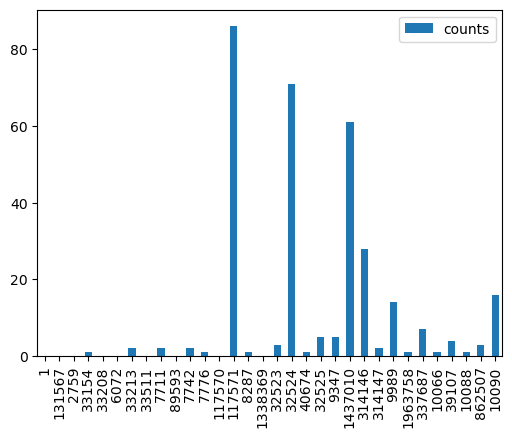

In [7]:
# show number of species along query lineage
of_species_abundance

# bar plot number of species along query lineage
of_species_abundance.plot.bar(y='counts', use_index=True)

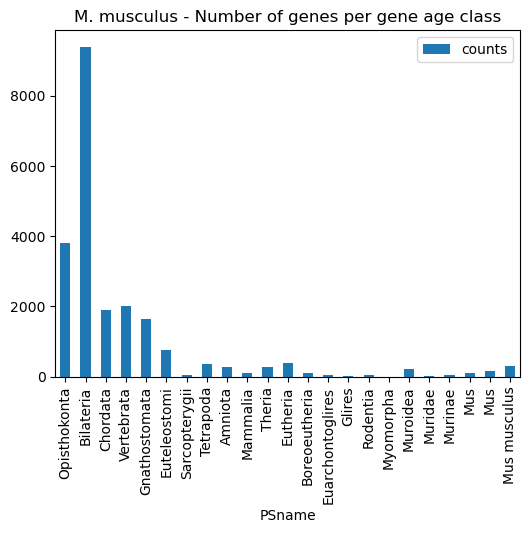

In [8]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(query_orthomap).plot.bar(y='counts', x='PSname')
ax.set_title('M. musculus - Number of genes per gene age class')
plt.show()

## Step 3 - map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `orthomap` and the `gtf2t2g.parse_gtf()` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

If in your case gene or transcript IDs between an orthomap and scRNA data do not match directly, please have a look at a detailed how-to to match them:

https://orthomap.readthedocs.io/en/latest/tutorials/geneset_overlap.html

In [9]:
datasets.mouse_ensembl110_gtf(datapath='data')

100% [........................................................................] 32302884 / 32302884

'data/Mus_musculus.GRCm39.110.gtf.gz'

In [10]:
# get gene to transcript table for Mus musculus

# download mouse GTF file here:
# https://ftp.ensembl.org/pub/release-110/gtf/mus_musculus/Mus_musculus.GRCm39.110.gtf.gz
# or download with datasets.mouse_ensembl110_gtf('data')
query_species_t2g = gtf2t2g.parse_gtf(
    gtf='data/Mus_musculus.GRCm39.110.gtf.gz',
    g=True, b=True, p=True, v=True, s=True, q=True)

56941 gene_id found
149547 transcript_id found
149547 protein_id found
0 duplicated


In [11]:
query_species_t2g

gene_id        gene_id_version       transcript_id  \
0       ENSMUSG00000000001   ENSMUSG00000000001.5  ENSMUST00000000001   
1       ENSMUSG00000000003  ENSMUSG00000000003.16  ENSMUST00000114041   
2       ENSMUSG00000000003  ENSMUSG00000000003.16  ENSMUST00000000003   
3       ENSMUSG00000000028  ENSMUSG00000000028.16  ENSMUST00000115585   
4       ENSMUSG00000000028  ENSMUSG00000000028.16  ENSMUST00000000028   
...                    ...                    ...                 ...   
149542  ENSMUSG00002076988   ENSMUSG00002076988.1  ENSMUST00020182589   
149543  ENSMUSG00002076989   ENSMUSG00002076989.1  ENSMUST00000083836   
149544  ENSMUSG00002076990   ENSMUSG00002076990.1  ENSMUST00020183326   
149545  ENSMUSG00002076991   ENSMUSG00002076991.1  ENSMUST00020182837   
149546  ENSMUSG00002076992   ENSMUSG00002076992.1  ENSMUST00020181762   

        transcript_id_version gene_name       gene_type          protein_id  \
0        ENSMUST00000000001.5     Gnai3  protein_coding  ENSMUSP00000000001   
1        ENSMUST00000114041.3      Pbsn  protein_coding  ENSMUSP00000109675   
2       ENSMUST00000000003.14      Pbsn  protein_coding  ENSMUSP00000000003   
3        ENSMUST00000115585.2     Cdc45  protein_coding  ENSMUSP00000111248   
4       ENSMUST00000000028.14     Cdc45  protein_coding  ENSMUSP00000000028   
...                       ...       ...             ...                 ...   
149542   ENSMUST00020182589.1   Gm56371            rRNA                None   
149543   ENSMUST00000083836.4   Gm23510           snRNA                None   
149544   ENSMUST00020183326.1   Gm22711          snoRNA                None   
149545   ENSMUST00020182837.1   Gm55627        misc_RNA                None   
149546   ENSMUST00020181762.1   Gm54807        misc_RNA                None   

          protein_id_version  
0       ENSMUSP00000000001.5  
1       ENSMUSP00000109675.3  
2       ENSMUSP00000000003.8  
3       ENSMUSP00000111248.2  
4       ENSMUSP00000000028.8  
...                      ...  
149542                  None  
149543                  None  
149544                  None  
149545                  None  
149546                  None  

[149547 rows x 8 columns]

### Import now, the scRNA dataset of the query species

Here, data is used, like in the publication ([Paul et al., 2015](http://doi.org/10.1016/j.cell.2015.11.013)).

scRNA data is imported via Scanpy ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)).

see also:

- [https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html)
- [https://morris-lab.github.io/CellOracle.documentation/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.html](https://morris-lab.github.io/CellOracle.documentation/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.html)

In [12]:
paul15 = sc.datasets.paul15()

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


### Get an overview of observations

In [13]:
paul15

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [14]:
paul15.obs

paul15_clusters
0               7MEP
1               15Mo
2               3Ery
3               15Mo
4               3Ery
...              ...
2725            2Ery
2726          13Baso
2727            7MEP
2728            15Mo
2729            3Ery

[2730 rows x 1 columns]

In [15]:
paul15.var

Empty DataFrame
Columns: []
Index: [0610007L01Rik, 0610009O20Rik, 0610010K14Rik, 0910001L09Rik, 1100001G20Rik, 1110002B05Rik, 1110004E09Rik, 1110007A13Rik, 1110007C09Rik, 1110013L07Rik, 1110020G09Rik, 1110034G24Rik, 1110038B12Rik, 1110049F12Rik, 1110059E24Rik, 1190002H23Rik, 1190007F08Rik, 1200002N14Rik, 1300001I01Rik, 1300017J02Rik, 1500001M20Rik, 1500012F01Rik, 1500032L24Rik, 1600014C10Rik, 1700001L05Rik, 1700012B09Rik, 1700017B05Rik, 1700020L24Rik, 1810009A15Rik, 1810011H11Rik, 1810027O10Rik, 1810030N24Rik, 1810031K17Rik, 1810033B17Rik, 1810037I17Rik, 2010002N04Rik, 2010011I20Rik, 2010106G01Rik, 2210016F16Rik, 2210020M01Rik, 2210023G05Rik, 2210404O07Rik, 2210411K11Rik, 2310003C23Rik, 2310003F16Rik, 2310005E10Rik, 2310014H01Rik, 2310022B05Rik, 2310028O11Rik, 2410006H16Rik, 2510002D24Rik, 2510003E04Rik, 2610018G03Rik, 2610024G14Rik, 2610029G23Rik, 2610029I01Rik, 2610035D17Rik, 2610101N10Rik, 2700094K13Rik, 2810004N23Rik, 2810417H13Rik, 2810474O19Rik, 2900010J23Rik, 2900010M23Rik, 2900026A02Rik, 2900073G15Rik, 3110003A17Rik, 3110056O03Rik, 4632415L05Rik, 4632428N05Rik, 4930473A06Rik, 4930486L24Rik, 4930503E24Rik, 4930534B04Rik, 4931406C07Rik, 5033406O09Rik, 5430435G22Rik, 5730469M10Rik, 5730508B09Rik, 5730528L13Rik, 5830405N20Rik, 5830432E09Rik, 6030458C11Rik, 6330416G13Rik, 6330503K22Rik, 6720456B07Rik, 8430419L09Rik, 8430427H17Rik, 9030617O03Rik, 9130206I24Rik, 9130208E07Rik, 9230105E10Rik, 9530068E07Rik, 9530077C05Rik, 9630033F20Rik, 9830001H06Rik, A030009H04Rik, A930001N09Rik, AA987161, AB124611, ...]

[3451 rows x 0 columns]

### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [16]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(paul15.var_names, query_orthomap['seqID'])

g1_g2_overlap  g1_ratio  g2_ratio
0              0       0.0       0.0

Since for OrthoFinder transcript IDs were used, there is no overlap between the var names of the scRNA data (`paul15.var_names`) and the orthomap (`query_orthomap['seqID']`). Based on the var names seen in the scRNA data one can try to use here the `gene_name` column of the `query_species_t2g` table to find possible overlaps.

In [17]:
# check overlap of transcript table <gene_id> and scRNA data <var_names>
orthomap2tei.geneset_overlap(paul15.var_names, query_species_t2g['gene_name'])

g1_g2_overlap  g1_ratio  g2_ratio
0           3044  0.882063  0.053893

Indeed overlaps are found and now can be used to match gene ages with the var names of the scRNA data.

**Note:** Not all gene names have been found (3044/3451), this can be due to spelling or typos. This is why it should be preferred to at least provide an additional column in the `adata.var` with a common `GeneID` from either `NCBI` or `ensembl`.

For example the gene name from the `adata.var_names` 'hnRNP A2/B1' is spelled 'Hnrnpa2b1' in the `ensembl` `GTF`. Any matching might be prone to these kind of problems which can be avoided by at least providing a `GeneID`.

Here, we use a mouse gene synonyms table (https://github.com/mustafapir/geneName/blob/master/data/mouse_synonyms1.rda) to assign them to the correct geneID, which is available here:

https://doi.org/10.5281/zenodo.7242263

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.mouse_synonyms(datapath='data')` (download folder set to `'data'`).

In [18]:
datasets.mouse_synonyms(datapath='data')

100% [..........................................................................] 1073171 / 1073171

'data/mouse_synonyms.tsv'

In [19]:
# get mouse gene synonyms

# download mouse gene synonyms table here: https://doi.org/10.5281/zenodo.7242263
# or download with datasets.mouse_synonyms(datapath='data')
mouse_synonyms = pd.read_csv('data/mouse_synonyms.tsv', delimiter='\t')

In [20]:
mouse_synonyms

Gene_name Gene_synonyms
0               Pzp           A1m
1               Pzp      AI893533
2             Aanat        AA-NAT
3             Aanat         Nat-2
4             Aanat          Nat4
...             ...           ...
67150  LOC116814569    EC(Mir290)
67151  LOC116915240   EC(Ranbp17)
67152  LOC116915241     EC(Esrrb)
67153  LOC116915242      EC(Mcl1)
67154  LOC116915243      EC(Etl4)

[67155 rows x 2 columns]

Here, only the genes that do not overlap with the `GTF` file gene names are searched among the synonyms and used to get a better overlap.

In [21]:
gene_names_no_overlap = paul15.var_names[~paul15.var_names.isin(query_species_t2g['gene_name'])].values
gene_names_to_be_replaced = mouse_synonyms[mouse_synonyms['Gene_synonyms'].isin(gene_names_no_overlap)]
gene_names_to_be_replaced

Gene_name  Gene_synonyms
1579      Casp4         Casp11
2121      Chil3         Chi3l3
3174      Ackr1           Darc
3265      Dnah8         Dnahc8
3793    Epb41l2       Epb4.1l2
...         ...            ...
61754   Foxd2os  9130206I24Rik
61933    Thoc2l  D930016D06Rik
62217   Morrbid        Gm14005
63500    Hbb-bs         Beta-s
63543   Gm10925        Atpase6

[231 rows x 2 columns]

In [22]:
len(set(gene_names_to_be_replaced['Gene_synonyms'].values))

228

As a result at best 228 additional genes can be added for mapping OrthoFinder results and the scRNA data.

Here, a new column `gene_name2` is added to the `query_species_t2g` object with the `Gene_synonyms` values keeping the original `gene_name` value if no match is found (set option `keep = True`).

In [23]:
# convert gene_name into Gene_synonyms and add a new column 'gene_name2' to query_species_t2g
query_species_t2g['gene_name2'] = orthomap2tei.replace_by(
    x_orig = list(query_species_t2g['gene_name']),
    xmatch = list(gene_names_to_be_replaced['Gene_name']),
    xreplace = list(gene_names_to_be_replaced['Gene_synonyms']),
    keep = True
)

Now, again the overlap is cheked as before.

In [24]:
# check overlap of transcript table <gene_id> and scRNA data <var_names>
orthomap2tei.geneset_overlap(paul15.var_names, query_species_t2g['gene_name2'])

g1_g2_overlap  g1_ratio  g2_ratio
0           3270  0.947551  0.057898

### Reduce isoforms to genes

The `of2orthomap.replace_by()` helper function can be used to add a new column to the orthomap dataframe by matching e.g. gene isoform names and their corresponding gene names.

In [25]:
query_orthomap

seqID Orthogroup  PSnum PStaxID            PSname  \
0      ENSMUST00000031086.5  OG0000000      6   33213         Bilateria   
1      ENSMUST00000035250.6  OG0000000      6   33213         Bilateria   
2      ENSMUST00000037071.5  OG0000000      6   33213         Bilateria   
3      ENSMUST00000038432.7  OG0000000      6   33213         Bilateria   
4      ENSMUST00000040983.6  OG0000000      6   33213         Bilateria   
...                     ...        ...    ...     ...               ...   
22013  ENSMUST00000096469.7  OG0029196     31   10090      Mus musculus   
22014  ENSMUST00000121900.8  OG0029196     31   10090      Mus musculus   
22015  ENSMUST00000249242.1  OG0029197     22  314146  Euarchontoglires   
22016  ENSMUST00000186194.2  OG0029198     31   10090      Mus musculus   
22017  ENSMUST00000189007.2  OG0029198     31   10090      Mus musculus   

       PScontinuity  
0          0.909091  
1          0.909091  
2          0.909091  
3          0.909091  
4          0.909091  
...             ...  
22013      1.000000  
22014      1.000000  
22015      0.200000  
22016      1.000000  
22017      1.000000  

[22018 rows x 6 columns]

In [26]:
paul15.var_names

Index(['0610007L01Rik', '0610009O20Rik', '0610010K14Rik', '0910001L09Rik',
       '1100001G20Rik', '1110002B05Rik', '1110004E09Rik', '1110007A13Rik',
       '1110007C09Rik', '1110013L07Rik',
       ...
       'hnRNP A2/B1', 'mFLJ00022', 'mKIAA0007', 'mKIAA0569', 'mKIAA0621',
       'mKIAA1027', 'mKIAA1575', 'mKIAA1994', 'rp9', 'slc43a2'],
      dtype='object', length=3451)

In [27]:
# convert orthomap transcript IDs into GeneNAMEs and add them to orthomap
query_orthomap['geneNAME'] = orthomap2tei.replace_by(
    x_orig = query_orthomap['seqID'],
    xmatch = query_species_t2g['transcript_id_version'],
    xreplace = query_species_t2g['gene_name2'],
)

In [28]:
# check overlap of orthomap <geneID> and scRNA data
orthomap2tei.geneset_overlap(paul15.var_names, query_orthomap['geneNAME'])

g1_g2_overlap  g1_ratio  g2_ratio
0           3242  0.939438  0.147901

**Note:** Not all genes might be present in the OrthoFinder results, this is why the overlap only shows (3242/3451).

## Step 4 - get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the phylostratum value) over all evolutionary age categories denoted as _phylostra_.

${TEI_s = \sum (e_{is} * ps_i) / \sum e_{is}}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_{is}}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${ps_i}$ denotes the corresponding phylostratum of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different gene age classes, their gene ages might differ based on the oldest ortholog found in their corresponding orthologous groups. However, both isoforms share the same gene name and their gene ages would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene age to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'older' gene age.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class or re-calculate other metrics. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [29]:
paul15.layers['counts'] = paul15.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `orthomap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

In [30]:
# add TEI values to existing adata object
orthomap2tei.get_tei(adata=paul15,
    gene_id=query_orthomap['geneNAME'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='Phylostrata',
    add_obs=True,
    obs_name='tei',
    boot=False,
    bt=10,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)

tei
0     5.420982
1     5.598349
2     5.361106
3     5.551194
4     5.362875
...        ...
2725  5.242296
2726  5.648879
2727  5.571817
2728  5.526262
2729  5.384177

[2730 rows x 1 columns]

## Step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned embryo stage and against assigned cell types of the zebrafish using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot gene age class per cluster

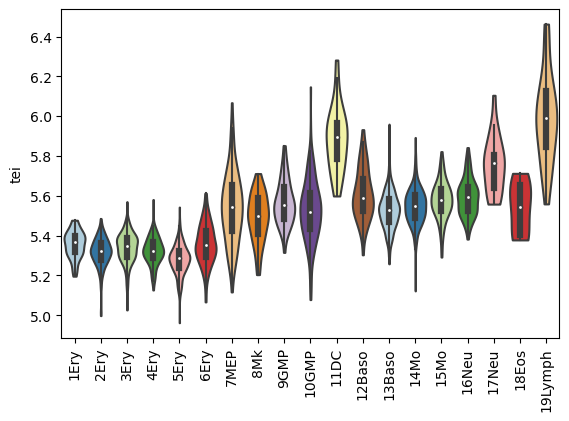

In [31]:
sc.pl.violin(adata=paul15,
             keys=['tei'],
             groupby='paul15_clusters',
             rotation=90,
             palette='Paired',
             stripplot=False,
             inner='box')

### Use cluster names as cell-type

Here, just the pre-existing observation `paul15_cluster` will be used to assign cell-types.

In [32]:
import re
paul15.obs['cell_type'] = [re.sub(r'\d', '', x) for x in list(paul15.obs['paul15_clusters'])]
paul15.obs

paul15_clusters       tei cell_type
0               7MEP  5.420982       MEP
1               15Mo  5.598349        Mo
2               3Ery  5.361106       Ery
3               15Mo  5.551194        Mo
4               3Ery  5.362875       Ery
...              ...       ...       ...
2725            2Ery  5.242296       Ery
2726          13Baso  5.648879      Baso
2727            7MEP  5.571817       MEP
2728            15Mo  5.526262        Mo
2729            3Ery  5.384177       Ery

[2730 rows x 3 columns]

### Boxplot gene age class per cell type

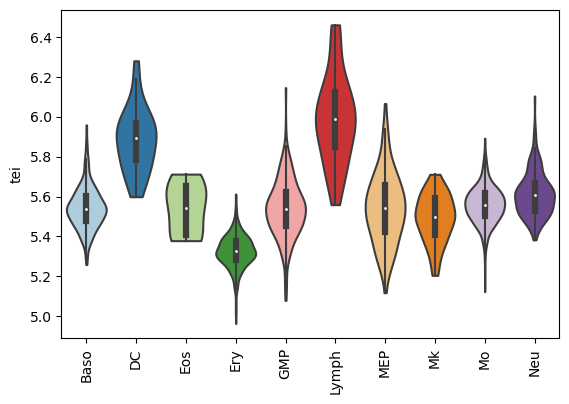

In [33]:
sc.pl.violin(adata=paul15,
             keys=['tei'],
             groupby='cell_type',
             rotation=90,
             palette='Paired',
             stripplot=False,
             inner='box')

### Plot relative expression per gene age class per cell type

In [34]:
paul15_rematrix_grouped = orthomap2tei.get_rematrix(
    adata=paul15,
    gene_id=query_orthomap['geneNAME'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    use='counts',
    var_type='mean',
    group_by_obs='cell_type',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=0,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
paul15_rematrix_grouped

cell_type      Baso        DC       Eos       Ery       GMP     Lymph  \
ps                                                                      
3          0.615039  0.167359  0.178835  1.000000  0.352897  0.000000   
6          0.628194  0.236375  0.198174  1.000000  0.343005  0.000000   
8          0.699730  0.277642  0.180843  1.000000  0.388863  0.003901   
10         0.713704  0.308461  0.229101  1.000000  0.377608  0.007057   
11         0.844724  0.517196  0.129400  0.989336  0.419327  0.393205   
13         0.742205  1.000000  0.078693  0.274903  0.387866  0.782465   
14         0.971625  1.000000  0.187126  0.290612  0.778844  0.909515   
16         0.640491  0.583502  0.509405  0.121767  0.373026  0.802505   
17         0.729319  0.279619  0.232445  0.916531  0.562699  0.191023   
18         0.034993  0.574783  0.163902  1.000000  0.000000  0.827045   
19         0.759602  0.824711  0.000000  0.523941  0.349168  1.000000   
20         0.773668  0.373523  0.290813  0.651809  0.364964  0.016123   
21         0.071850  0.000000  0.000000  0.152816  0.000000  1.000000   
22         0.740743  0.550511  0.428294  0.772036  0.334820  0.191008   
26         0.483313  0.968952  0.104028  0.504886  0.357192  1.000000   
29         1.000000  0.466556  0.000000  0.041245  0.611573  0.200193   

cell_type       MEP        Mk        Mo       Neu  
ps                                                 
3          0.036377  0.373524  0.709971  0.517142  
6          0.035514  0.396302  0.738885  0.560596  
8          0.000000  0.350501  0.854512  0.653597  
10         0.000000  0.480066  0.872604  0.730671  
11         0.000000  0.407798  1.000000  0.708744  
13         0.000000  0.317121  0.920760  0.660845  
14         0.000000  0.298576  0.967717  0.553341  
16         0.000000  0.156255  0.970238  1.000000  
17         0.000000  0.426007  0.915294  1.000000  
18         0.067891  0.822250  0.164334  0.258132  
19         0.094374  0.321299  0.640921  0.451999  
20         0.000000  0.279758  1.000000  0.798367  
21         0.000000  0.347615  0.047269  0.143393  
22         0.000000  0.575763  1.000000  0.841191  
26         0.000000  0.068826  0.529742  0.355046  
29         0.076297  0.036560  0.818541  0.384647

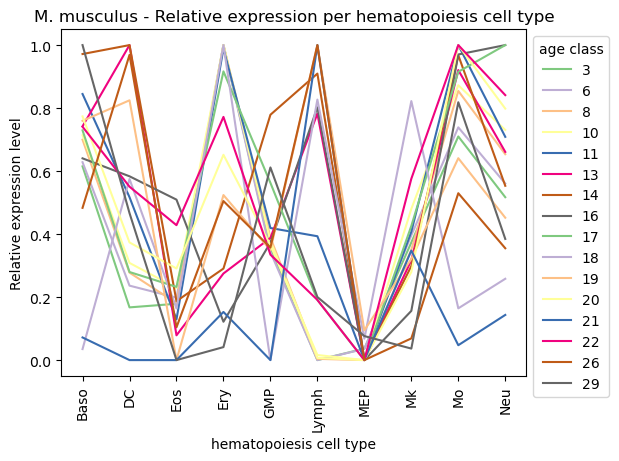

In [35]:
ax = sns.lineplot(paul15_rematrix_grouped.transpose(), palette='Accent', dashes=False)
ax.legend(fontsize=5, title='age class')
ax.set_title('M. musculus - Relative expression per hematopoiesis cell type')
ax.set_xlabel('hematopoiesis cell type')
ax.set_ylabel('Relative expression level')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
#plt.tick_params(labelsize=3)
plt.xticks(rotation=90)
plt.show()

### Get partial TEI values to visualize gene age class contributions

Partial `TEI` values can give an idea about which gene age class contributed at most to the `global` `TEI` pattern.

In detail, each gene gets a `TEI` contribution profile as follows:

${TEI_{is} = f_{is} * ps_i}$

, where ${TEI_{is}}$ is the partial `TEI` value of gene ${i}$, ${f_{is} = e_{is} / \sum e_{is}}$ and ${ps_i}$ is the phylostratum of gene i.

${TEI_{is}}$ values are combined per ${ps}$.

The partial `TEI` values combined per strata give an overall impression of the contribution of each strata to the `global` `TEI` pattern.

One can either start from `counts` (`adata.X`) which is set as default or any other `layer` defined by the `layer` option (`layer=None`).

In addition, the `counts` can be `normalized` and `log-transformed` prior calculating partial `TEI` values (`normalize_total=False`, `log1p=False`, `target_sum=1e6`).

Further, these values can be combined per given observation, e.g. cell typer per sample timepoint (`group_by='cell_state'`).

The `get_pstrata` function of the `orthomap2tei` submodule will return two matrix, the first contains the sum of each partial `TEI` per gene age class and the second the corresponding frequencies.

Both can be further processed by returning the `cumsum` over the gene age classes. To get them set the option `cumsum=True`. The `cumsum` will result in either for the first matrix the `TEI` value per cell or mean `TEI` value per group, if one choose a observation with the `group_by` option. Or in case of the second frequency matrix will result in 1.

With the `standard_scale` option either gene age classes (`standard_scale=0` rows) or cells or groups (`standard_scale=1` columns) can be scaled, subtract the minimum and divide each by its maximum. By default no scaling is applied (`standard_scale=None`).

The resulting data will be visualized in the downstream section.

In [36]:
paul15_pstrata = orthomap2tei.get_pstrata(adata=paul15,
    gene_id=query_orthomap['geneNAME'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    cumsum=False,
    group_by_obs='cell_type',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=None,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
paul15_pstrata[0]

cell_type      Baso        DC       Eos       Ery       GMP     Lymph  \
ps                                                                      
3          1.255834  1.148338  1.233771  1.310048  1.262417  1.161642   
6          2.480437  2.502566  2.522931  2.517643  2.462211  2.396045   
8          0.411742  0.434993  0.419678  0.386126  0.413464  0.409350   
10         0.519061  0.523463  0.558027  0.488053  0.509677  0.508627   
11         0.301539  0.378470  0.272956  0.253081  0.304966  0.463461   
13         0.244590  0.433666  0.228817  0.141298  0.252155  0.497386   
14         0.044808  0.071361  0.039175  0.022380  0.052420  0.085155   
16         0.050629  0.077074  0.071406  0.027087  0.054985  0.108249   
17         0.082491  0.091259  0.084651  0.073984  0.097491  0.111185   
18         0.007005  0.020789  0.010993  0.014049  0.008381  0.035249   
19         0.019848  0.031870  0.002873  0.011493  0.014289  0.053635   
20         0.078326  0.083061  0.067107  0.053517  0.066933  0.056529   
21         0.000092  0.000000  0.000000  0.000103  0.000000  0.002859   
22         0.010988  0.011637  0.015828  0.008569  0.007818  0.007517   
26         0.022055  0.067426  0.012997  0.016827  0.022783  0.086933   
29         0.013402  0.007264  0.000000  0.000478  0.009943  0.005890   

cell_type       MEP        Mk        Mo       Neu  
ps                                                 
3          1.236535  1.254041  1.249693  1.221387  
6          2.523230  2.519323  2.481219  2.503882  
8          0.401669  0.391083  0.416381  0.423759  
10         0.494315  0.535641  0.533390  0.563985  
11         0.331846  0.288934  0.295967  0.298528  
13         0.273134  0.230809  0.246127  0.249142  
14         0.043136  0.037238  0.041165  0.037326  
16         0.058365  0.041914  0.053758  0.064512  
17         0.087944  0.083058  0.084383  0.104090  
18         0.013827  0.020053  0.007336  0.009939  
19         0.010245  0.012994  0.016351  0.014169  
20         0.054852  0.056434  0.086404  0.085647  
21         0.000000  0.000183  0.000060  0.000194  
22         0.003262  0.010725  0.013529  0.013286  
26         0.007268  0.008683  0.022500  0.018088  
29         0.002479  0.000404  0.009816  0.005076

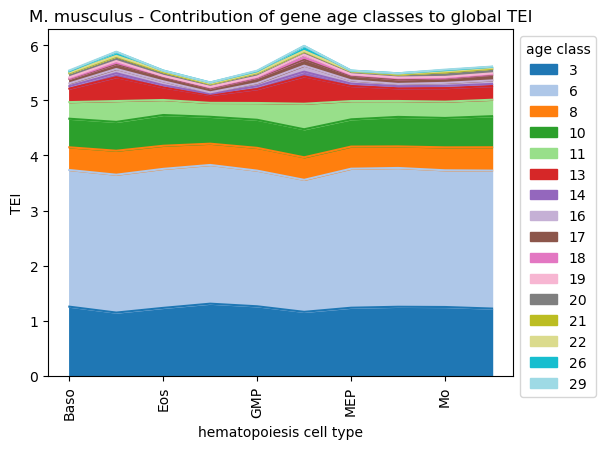

In [37]:
#plt.rcParams['figure.figsize'] = [9, 4.5]
ax=paul15_pstrata[0].transpose().plot.area(cmap='tab20')
ax.legend(fontsize=3, title='age class')
ax.set_title('M. musculus - Contribution of gene age classes to global TEI')
ax.set_xlabel('hematopoiesis cell type')
ax.set_ylabel('TEI')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()
#plt.rcParams['figure.figsize'] = [6, 4.5]

### Color UMAP/TSNE by TEI

Follwoing the tutorial of CellOracle ([Kamimoto et al., 2023](https://www.nature.com/articles/s41586-022-05688-9)), one can highlight `TEI` values on a dimensional reduction of the scRNA dataset, like `PCA`, `UMAP` or `TSNE`.

#### Filtering

In [38]:
# Only consider genes with more than 1 count
sc.pp.filter_genes(paul15, min_counts=1)

#### Normalization

In [39]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(paul15, key_n_counts='n_counts_all')

### Identification of highly variable genes

Removing non-variable genes reduces the calculation time during the GRN reconstruction and simulation steps. It also improves the overall accuracy of the GRN inference by removing noisy genes. We recommend using the top 2000~3000 variable genes.

In [40]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(paul15.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset the genes
paul15 = paul15[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(paul15)

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


### Log transformation

We need to log transform and scale the data before we calculate the principal components, clusters, and differentially expressed genes.

We also need to keep the non-transformed gene expression data in a separate anndata layer before the log transformation. We will use this data for celloracle analysis later.

In [41]:
# keep raw cont data before log transformation
paul15.raw = paul15
paul15.layers["raw_count"] = paul15.raw.X.copy()

# Log transformation and scaling
sc.pp.log1p(paul15)
sc.pp.scale(paul15)

### PCA and neighbor calculations

These calculations are necessary to perform the dimensionality reduction and clustering steps.

In [42]:
# PCA
sc.tl.pca(paul15, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(paul15, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(paul15)
# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(paul15, n_neighbors=10, use_rep='X_diffmap')

### Cell clustering

In [43]:
sc.tl.louvain(paul15, resolution=0.8)

### Embedding the neighborhood graph

In [44]:
# PAGA graph construction
sc.tl.paga(paul15, groups='louvain')

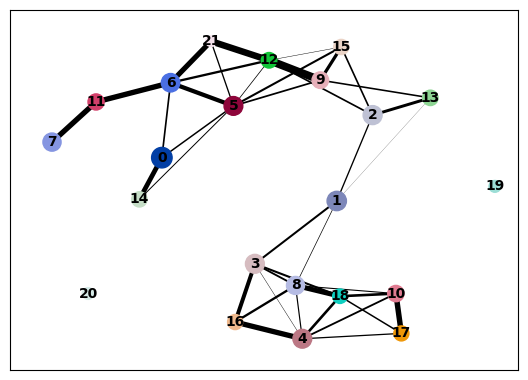

In [45]:
sc.pl.paga(paul15)

### Color PAGA graph

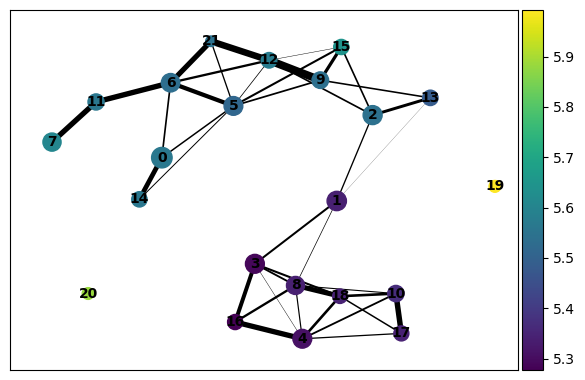

In [46]:
sc.pl.paga(paul15, color='tei')

In [47]:
sc.tl.draw_graph(paul15, init_pos='paga', random_state=123)

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


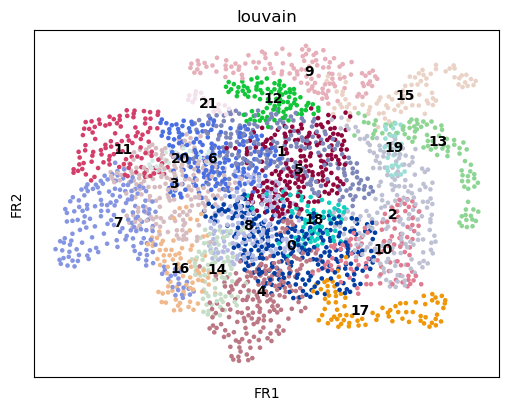

In [48]:
sc.pl.draw_graph(paul15, color='louvain', legend_loc='on data')

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


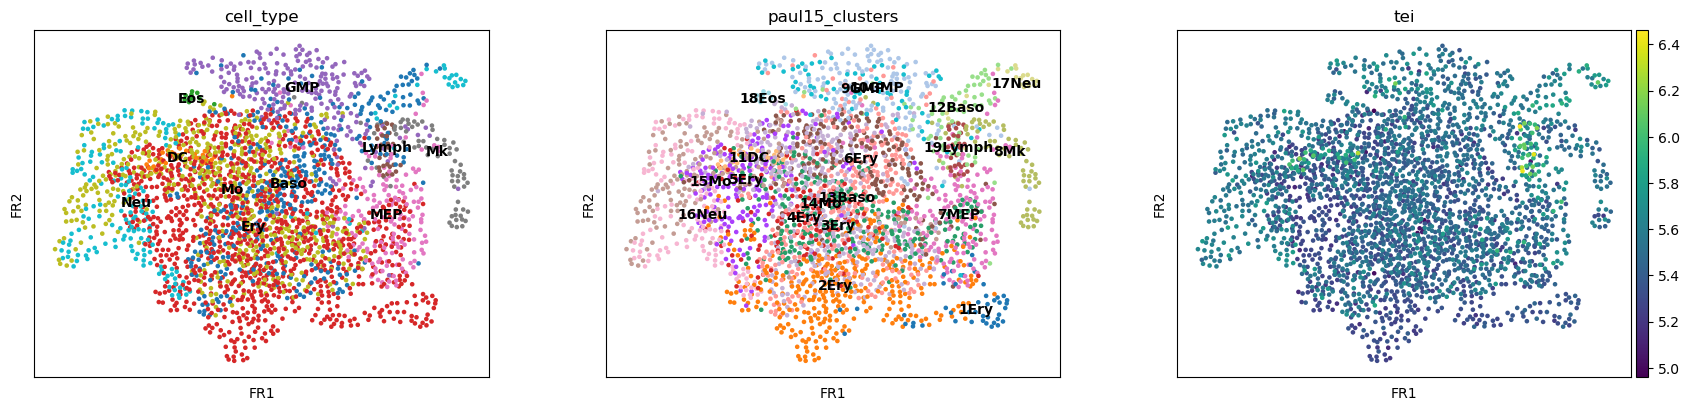

In [49]:
sc.pl.draw_graph(paul15, color=['cell_type', 'paul15_clusters', 'tei'],
                 legend_loc='on data')

#### UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


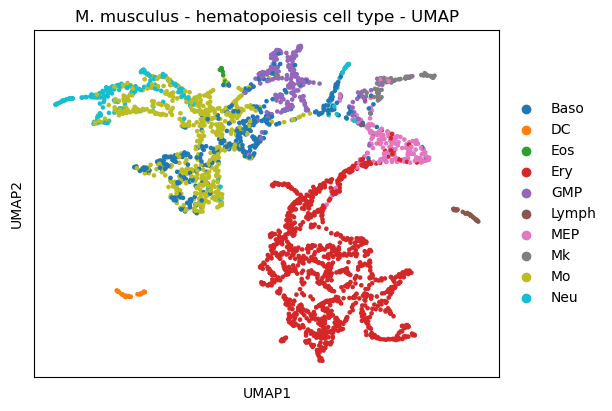

In [50]:
sc.tl.umap(paul15,
           init_pos='paga')
sc.pl.umap(paul15,
           title='M. musculus - hematopoiesis cell type - UMAP', color=['cell_type'])

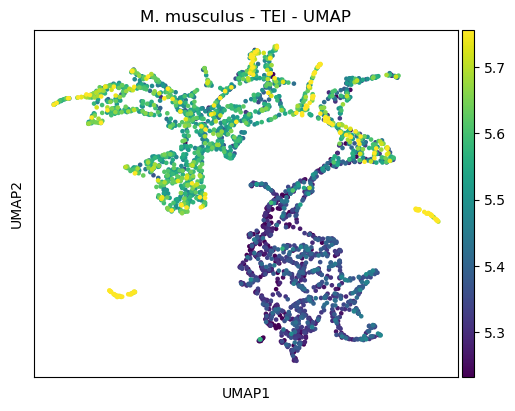

In [52]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(paul15,
           title='M. musculus - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


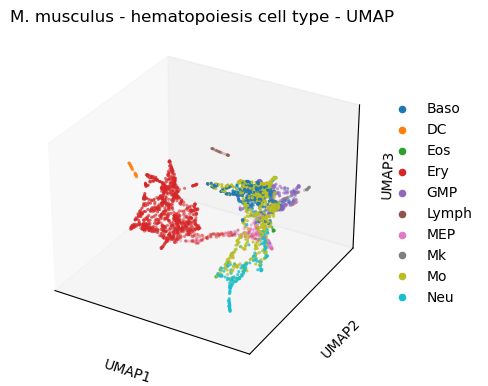

In [53]:
#3d
sc.tl.umap(paul15,
           n_components=3)
sc.pl.umap(paul15,
           title='M. musculus - hematopoiesis cell type - UMAP', color=['cell_type'],
           projection='3d')

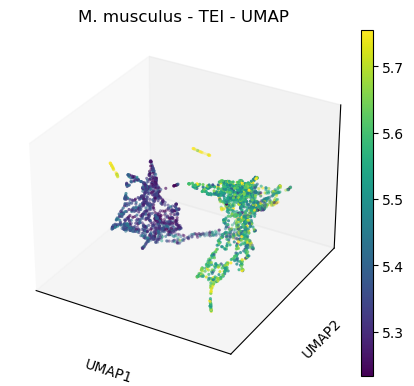

In [54]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(paul15,
           title='M. musculus - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95',
           projection='3d')
#plt.rcParams['figure.figsize'] = [6, 4.5]

In [55]:
import plotly
import kaleido
import plotly.express as px
plotly.offline.init_notebook_mode(connected=False)

In [56]:
df = pd.DataFrame( {'UMAP1':paul15.obsm['X_umap'][:,0], 
                    'UMAP2':paul15.obsm['X_umap'][:,1],
                    'UMAP3':paul15.obsm['X_umap'][:,2],
                    'cell_type':paul15.obs['cell_type'].values.astype(str),
                    'tei':paul15.obs['tei'].values,
                    'cell_id':paul15.obs.index.to_list()  } ) 
df.set_index('cell_id', inplace = True)
df.head()

UMAP1     UMAP2      UMAP3 cell_type       tei
cell_id                                                    
0        11.113059  7.795863  -0.662884       MEP  5.420982
1        16.109194  0.734038  11.387341        Mo  5.598349
2         3.196870 -5.445777   6.057778       Ery  5.361106
3        13.342421  0.143536   4.945064        Mo  5.551194
4         3.316909 -3.929081   6.646379       Ery  5.362875

In [57]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='cell_type')
fig.update_traces(marker_size = 2)
fig.write_html('mouse_scatter_3d_cell_type.html')

In [58]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='tei',
                    range_color=(5,5.5))
fig.update_traces(marker_size = 2)
fig.write_html('mouse_scatter_3d_tei.html')

Please have a look at the documentation for other [case studies](https://orthomap.readthedocs.io/en/latest/tutorials/index.html#case-studies).